<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/main/ATE_Candy_Propensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import make_scorer, balanced_accuracy_score


from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut  , StratifiedKFold , cross_val_score , cross_val_predict
from scipy.stats import uniform , randint

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [46]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [47]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [48]:
data.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent'],
      dtype='object')

In [49]:
c1 = data ['chocolate'] == 0
c2 = data ['fruity'] == 0
c  = c1 & c2

data ["other_candy"] = np.where (c , 1 , 0)

In [50]:
data ["winpercent"] = data ["winpercent"] / 100

In [51]:
decision_cols = ['chocolate', 'fruity', 'other_candy' ,'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']
cont_cols     = ['sugarpercent','winpercent' ,'pricepercent' ]

array([[<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'fruity'}>,
        <Axes: title={'center': 'other_candy'}>],
       [<Axes: title={'center': 'caramel'}>,
        <Axes: title={'center': 'peanutyalmondy'}>,
        <Axes: title={'center': 'nougat'}>],
       [<Axes: title={'center': 'crispedricewafer'}>,
        <Axes: title={'center': 'hard'}>,
        <Axes: title={'center': 'bar'}>],
       [<Axes: title={'center': 'pluribus'}>, <Axes: >, <Axes: >]],
      dtype=object)

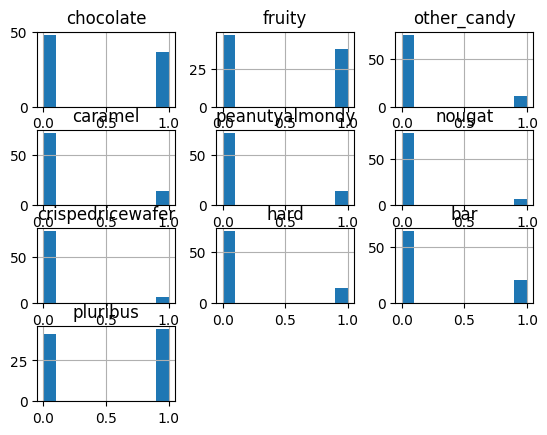

In [52]:
data [decision_cols].hist ()

In [53]:
data [decision_cols].nunique ()

chocolate           2
fruity              2
other_candy         2
caramel             2
peanutyalmondy      2
nougat              2
crispedricewafer    2
hard                2
bar                 2
pluribus            2
dtype: int64

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df = data.copy (deep = True)

# Selecting the treatment and outcome variables
treatment_col = 'peanutyalmondy'
outcome_col = 'winpercent'

# Selecting confounders (all binary variables excluding treatment)
confounders = [col for col in df.columns if col not in [treatment_col,
                                                        outcome_col,
                                                        'competitorname' ,
                                                        'fruity' ,
                                                        'other_candy',
                                                        'chocolate',
                                                        'bar']]

# Prepare data for modeling
X = pd.concat ([df [[outcome_col]] ,df[confounders]] ,axis =1)
X = df[confounders]
y = df[treatment_col]

# Fit logistic regression model to estimate propensity scores
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X, y)

# Propensity scores
cross_val_predict
df['propensity_score'] = logistic_model.predict_proba(X)[:, 1]
df['propensity_score'] = cross_val_predict(logistic_model ,
                                           X, y ,
                                           method = 'predict_proba',
                                           cv = LeaveOneOut ()) [:, 1]

# Show first few propensity scores
df[['competitorname', 'propensity_score', treatment_col]].head()


,competitorname,propensity_score,peanutyalmondy
0,100 Grand,0.255617,0
1,3 Musketeers,0.392482,0
2,One dime,0.147926,0
3,One quarter,0.220940,0
4,Air Heads,0.275422,0


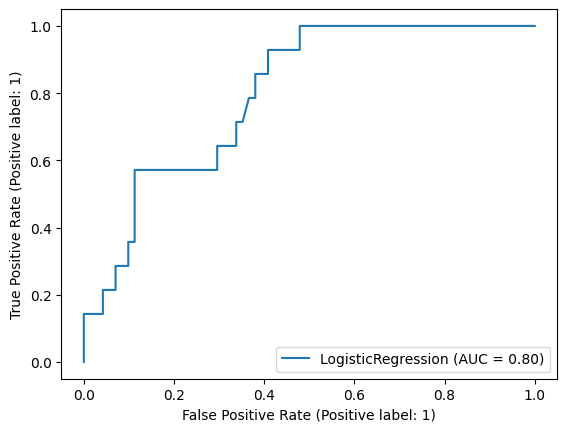

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import load_wine

RocCurveDisplay.from_estimator(logistic_model, X, y)

In [71]:
Treatment_Control_df      = df.copy(deep = True)
c                         = Treatment_Control_df ["propensity_score"] >= 0.5
Treatment_Control_df ["treatment_group"] = np.where (c , 'Treated', 'Control')
Treatment_Control_df

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,other_candy,propensity_score,treatment_group
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,0.669717,0,0.255617,Control
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,0.676029,0,0.392482,Control
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,0.322611,1,0.147926,Control
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,0.461165,1,0.220940,Control
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,0.523415,0,0.275422,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,0.454663,0,0.155095,Control
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,0.390119,0,0.062298,Control
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,0.443755,0,0.102792,Control
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,0.419043,1,0.065958,Control


In [72]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Separate the treated and control groups
treated = df[df[treatment_col] == 1]
control = df[df[treatment_col] == 0]

# Fit nearest neighbor model on control group
nn = NearestNeighbors(n_neighbors=1 , radius=0.1)
nn.fit(control[['propensity_score']])

# Find the nearest neighbors for each treated sample
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control_indices = indices.flatten()
matched_control = control.iloc[matched_control_indices] # Matched Control to Treatment

# Combine treated and matched control into one DataFrame
matched_data = pd.concat([treated, matched_control])
matched_data['treatment_group'] = np.where(matched_data[treatment_col] == 1, 1, 0)
#matched_data ['treatment_group'].iloc [matched_control_indices]  = 0
#matched_data ['treatment_group'].iloc [[i for i in range (matched_data.shape [1]) if i not in matched_control_indices ]] = 1


# Calculate average treatment effect (ATE)
ate = matched_data.groupby('treatment_group')[outcome_col].mean().diff().iloc[-1]
ate, matched_data[['competitorname', treatment_col, 'treatment_group', 'propensity_score', outcome_col]].head()


(0.08243798357142862,
          competitorname  peanutyalmondy  treatment_group  propensity_score  \
 5            Almond Joy               1                1          0.262685   
 6             Baby Ruth               1                1          0.291225   
 7    Boston Baked Beans               1                1          0.102444   
 32  Peanut butter M&M's               1                1          0.132193   
 40          Mr Good Bar               1                1          0.280716   
 
     winpercent  
 5     0.503475  
 6     0.569145  
 7     0.234178  
 32    0.714651  
 40    0.545265  )

In [73]:
matched_data[['competitorname', treatment_col, 'treatment_group', 'propensity_score', outcome_col]]


,competitorname,peanutyalmondy,treatment_group,propensity_score,winpercent
5,Almond Joy,1,1,0.262685,0.503475
6,Baby Ruth,1,1,0.291225,0.569145
7,Boston Baked Beans,1,1,0.102444,0.234178
32,Peanut butter M&M's,1,1,0.132193,0.714651
40,Mr Good Bar,1,1,0.280716,0.545265
42,Nestle Butterfinger,1,1,0.270000,0.707356
46,Payday,1,1,0.331672,0.462966
47,Peanut M&Ms,1,1,0.129674,0.694838
51,Reese's Miniatures,1,1,0.130927,0.818663
52,Reese's Peanut Butter cup,1,1,0.247243,0.841803


array([[<Axes: title={'center': 'peanutyalmondy'}>,
        <Axes: title={'center': 'treatment_group'}>],
       [<Axes: title={'center': 'propensity_score'}>,
        <Axes: title={'center': 'winpercent'}>]], dtype=object)

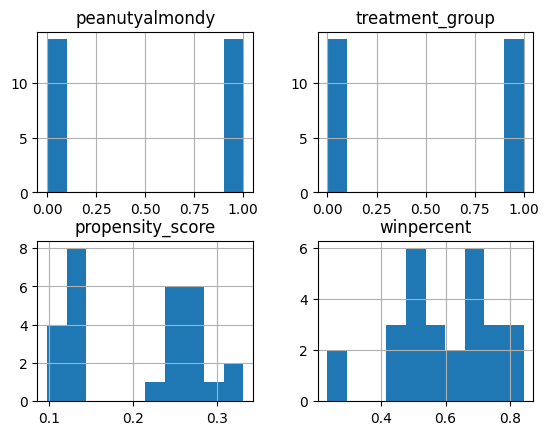

In [74]:
matched_data[[treatment_col, 'treatment_group', 'propensity_score', outcome_col]].hist ()


<Axes: xlabel='propensity_score', ylabel='winpercent'>

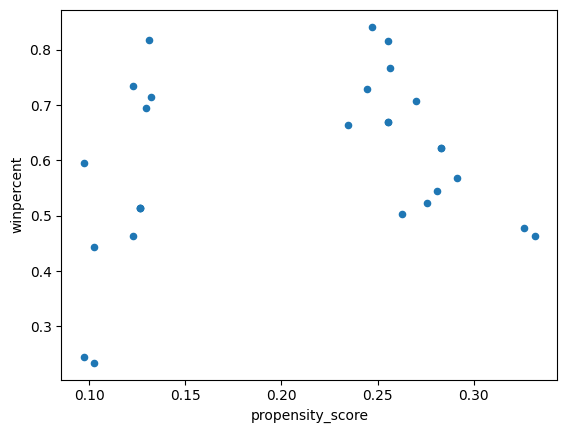

In [75]:
matched_data[['propensity_score', outcome_col]].plot.scatter ( 'propensity_score' , outcome_col )